# Adaptive Tensor Product Grids - Applied to HANK

The **choice of grids** when solving an economic model is somewhat of an **art**. Choosing grids in a smart way can substantially reduce the computational burden of solving a model leaving results unchanged. 

In **general equilibrium** and **structural estimation** applications, the model needs to be solved repeatedly, and it is therefore particularily benefial to spend some time initially on choosing the grids wisely.

In this notebook, I propose a method for choosing **tensor product grids in an adaptive manner**. Algorithms exists for choosing adaptive sparse grids, but this requires that the solution method is changed to handle these more complex grids. This is not always possible, or might be cumbersome.

The main idea is to **remove grid points where the function of interest is linear**.

The **algorithm** in words is:

1. Solve the model on a **fine tensor product grid** of your arbitrary choice
2. **Initialize** the **adaptive tensor product grid** to the fine grid
3. For each *second* grid point (not including the last) in each dimension, compute the **maximum absolute relative errror leaving this grid point out and using linear interpolation instead**. The  error is computed using the result at the fine tensor product grid and interpolation across the values in the current adaptive tensor product grid. The maximum is computed across all combinations of the grid points in the remaining dimensions.
4. **Remove grids points** where the maximum absolute relative error is below some tolerance, and **update the adaptive tensor product grids** accordingly.
5. **Stop if** no grid points were removed
6. (*Optional*) **Re-solve the model** on the adaptive tensor product grid (else use the values from the solution fine grid).
7. Return to step 3

**Note I:** The above algorithm only requires solving the model once if step 6 is skipped.

**Note II:** Re-solving the model will not result in the same values. The optional step 6 solves this.

**Note III:** A termination based on a simulation result could be added.

# Setup

In [1]:
from consav.runtools import write_numba_config
write_numba_config(disable=0,threads=20,threading_layer='omp')

In [2]:
import os
import time
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
colors = [x['color'] for x in plt.style.library['seaborn']['axes.prop_cycle']]
markers = ['s','P','D','v','^','*']

%load_ext autoreload
%autoreload 2

from consav.misc import elapsed
from consav import linear_interp
from TwoAssetModelCont import TwoAssetModelContClass

# Solve HANK for fine grid in $a$-dimension

In [3]:
t0 = time.time()
model = TwoAssetModelContClass(name='HANK',like_HANK=True)
print(f'model created in {elapsed(t0)}')

model created in 28.4 secs


In [4]:
# a. set fine grid in a dimension
model.par.Na = 200
model.par.KFEtol = 1e-8 # with larger (original) KFEtol, wont converge
# b. solve for fine grid
model.solve()
# c. save model solution for plotting later
model.calculate_moments(do_MPC=True)
model_fine = model

Grids created in 6.4 secs
Solution prepared in 7.6 secs
Solving HJB:
    1: 84.1700730791792466
    2: 38.2038971698338514
    3: 31.1125314480001975
    4: 30.4469082546748666
    5: 20.4968912764180615
    6: 19.4661796129954467
    7: 15.1727371142017944
    8: 12.9574056574936805
    9: 11.0695151551121711
  100: 0.0000102698259070
 converged in 3.0 mins 5 secs in iteration 146

Solving KFE:
    1: 617936907.3854777812957764
    2: 2436369.1853132443502545
    3: 161638.3345649561670143
    4: 141659.3809734772657976
    5: 51098.0943056882533710
    6: 56267.1547527411894407
    7: 19191.3581065573962405
    8: 34162.1902245900710113
    9: 15908.6761711678991560
  100: 0.0038568567397306
 converged in 35.8 secs secs in iteration 189


# Adaptive tensor product grid algorithm

In [5]:
tol = 1e-4

par = model.par
sol = model.sol

# fine indices
grid_a = par.grid_a
grid_ia = np.arange(par.Na,dtype=np.int64)
grid_ia_approx = np.arange(par.Na,dtype=np.int64)
sol_true_v = sol.v.copy() # v is sufficient as g is generated (implicitly) from v solution
sol_approx_v = sol_true_v.copy()

In [6]:
# iterate
it = 0
while it < 100:
    
    # a. number of grid points
    Na_approx  = grid_ia_approx.size
    
    # b. vectors for including or not
    Ia_approx = np.ones(Na_approx,dtype=np.bool_)  

    # c. a dimension
    for ia_ in range(1,Na_approx,2):
        
        if ia_ == Na_approx-1: continue # interpolation not possible
        
        # a. solution at fine
        ia = grid_ia_approx[ia_]
        true_v = sol_true_v[:,ia,:]
        
        # b. neighbors in adaptive
        ia_u = grid_ia_approx[ia_+1]
        ia_d = grid_ia_approx[ia_-1]
        
        # c. interpolation
        w = (grid_a[ia_u]-grid_a[ia])/(grid_a[ia_u]-grid_a[ia_d])
        approx_v = w*sol_true_v[:,ia_d,:] + (1-w)*sol_true_v[:,ia_u,:]
        
        # d. error
        max_abs_error_v = np.max(np.abs(true_v-approx_v)/true_v)
        Ia_approx[ia_] = True if max_abs_error_v > tol else False
    
    # e. update adaptive
    grid_ia_approx = grid_ia_approx[Ia_approx]
    
    sol_approx_v = sol_approx_v[:,Ia_approx,:]

    # f. check
    removed = np.sum(~Ia_approx)
    share = grid_ia_approx.size/grid_a.size
    print(f'{it}: {removed:6d} grids points removed, share of grid points remaining {share:.4f}')
    
    if removed == 0: break
    it += 1

# constructive adaptive
grid_a_approx = grid_a[grid_ia_approx]

0:     18 grids points removed, share of grid points remaining 0.9100
1:      9 grids points removed, share of grid points remaining 0.8650
2:      4 grids points removed, share of grid points remaining 0.8450
3:      2 grids points removed, share of grid points remaining 0.8350
4:      1 grids points removed, share of grid points remaining 0.8300
5:      0 grids points removed, share of grid points remaining 0.8300


**Effectiveness:** We see that approx. 20% of grid points are removed.

In [7]:
print(f'grids points for a-dimension is {grid_a_approx.size} [fine: {grid_a.size}]')

grids points for a-dimension is 166 [fine: 200]


# Approximation error

In [8]:
from consav import linear_interp
max_rel_abs_error = -np.inf
for iz,z in enumerate(par.grid_z):
    for ia,a in enumerate(par.grid_a):
        for ib,b in enumerate(par.grid_b):
            interp = linear_interp.interp_3d(par.grid_z,grid_a_approx,par.grid_b,sol_approx_v,z,a,b) # interp 3d
            true = sol_true_v[iz,ia,ib]
            max_rel_abs_error = np.fmax(max_rel_abs_error,np.abs(true-interp)/true)
        
print(f'max_rel_abs_error = {max_rel_abs_error:.8f}')

max_rel_abs_error = 0.00003031


**Precision:**  Somewhat better than the tolerance of 1e-4.

# Figures

**Re-solve model for small grid**

In [9]:
# a. set reduced grid in a dimension
model.par.Na = grid_a_approx.size
# b. solve for fine grid
model.solve(load_grid=True,grid_a=grid_a_approx)
# c. save for plotting
model.calculate_moments(do_MPC=True)
model_small = model

Grids created in 0.6 secs
Solution prepared in 0.8 secs
Solving HJB:
    1: 84.1700730791792751
    2: 38.2038875539894462
    3: 31.1125296448038036
    4: 30.4469064940903458
    5: 20.4968915947251986
    6: 19.4661783969291804
    7: 15.1727370892407265
    8: 12.9574049184251976
    9: 11.0695150970310152
  100: 0.0000102698863316
 converged in 2.0 mins 19 secs in iteration 146

Solving KFE:
    1: 12082.6751782090286724
    2: 2858.2324559627040799
    3: 949.2602355203134721
    4: 268.1175647215090976
    5: 248.8589010147994713
    6: 101.3112630957880356
    7: 82.3531891767371462
    8: 65.1601673689161771
    9: 48.3709452523910386
  100: 0.0000228479765795
 converged in 28.3 secs secs in iteration 189


**Plot comparison**

AY with a fine grid: 4.05987351
AY with a small grid: 4.05987351
Avg. MPC with a fine grid: 0.15433399
Avg. MPC with a small grid: 0.15433399


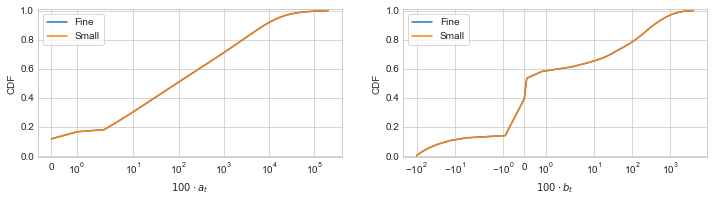

In [50]:
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(2,2,1)
ax.set_xscale('symlog')
ax.plot(model_fine.par.grid_a*100,model_fine.moms['a_margcum'])
ax.plot(model_small.par.grid_a*100,model_small.moms['a_margcum'])
ax.set_xlabel('$100 \cdot a_t$')
ax.set_ylabel(f'CDF')
ax.set_ylim([-0.01,1.01])
ax.legend(['Fine','Small'],frameon=True)

ax = fig.add_subplot(2,2,2)
ax.set_xscale('symlog')
ax.plot(model_fine.par.grid_b*100,model_fine.moms['b_margcum'])
ax.plot(model_small.par.grid_b*100,model_small.moms['b_margcum'])
ax.set_xlabel('$100 \cdot b_t$')
ax.set_ylabel(f'CDF')
ax.set_ylim([-0.01,1.01])
ax.legend(['Fine','Small'],frameon=True)

print(f"AY with a fine grid: {model_fine.moms['AY']:.8f}")
print(f"AY with a small grid: {model_small.moms['AY']:.8f}")

print(f"Avg. MPC with a fine grid: {model_fine.moms['MPC']:.8f}")
print(f"Avg. MPC with a small grid: {model_small.moms['MPC']:.8f}")